In [1]:
%matplotlib inline
#from typing import Dict, Tuple, List, Union, Iterable

import matplotlib.pyplot as plt
#import matplotlib.patches as mpatches
#from matplotlib.ticker import AutoMinorLocator
plt.style.use("lm")
import numpy as np
#import scipy.linalg as sl #expm
#import os
#import time
#import random
#import string
#import copy
#from tabulate import tabulate
import samplebase as sb

import path_utils as putils

In [2]:
from decimal import Decimal

def fexp(number):
    (sign, digits, exponent) = Decimal(number).as_tuple()
    return len(digits) + exponent - 1

def fman(number):
    return Decimal(number).scaleb(-fexp(number)).normalize()

def to_latex_value_with_err(value, err, n_round=1, include_math_env=False):
    assert abs(value) > abs(err)
    val_exp = fexp(value)
    err_2 = err / (10**val_exp)
    n_round = max(-1*fexp(err_2),n_round)
    err_man = round(err_2, n_round)
    val_man = round(fman(value), n_round)
    val_str = ("{:0." + str(n_round) + "f}").format(val_man)
    err_str = ("{:0." + str(n_round) + "f}").format(err_man)
    if val_exp==0:
        result = val_str + " \pm " + err_str
    else:
        result = r"( " + val_str + " \pm " + err_str + r")\times 10^" + "{" + str(val_exp) +"}"
    if include_math_env:
        result = r"$ " + result + r" $"
    return result

def to_latex_value(value, n_round=1, include_math_env=False):
    val_exp = fexp(value)
    val_man = round(fman(value), n_round)
    val_str = ("{:0." + str(n_round) + "f}").format(val_man)
    if val_exp==0:
        result = val_str
    else:
        result = val_str + r"\times 10^" + "{" + str(val_exp) +"} "
    
    if include_math_env:
        result = r"$ " + result + r" $"
    return result

print(to_latex_value_with_err(1e-3, 0.5e-6))
print(to_latex_value(4e-3))
print(to_latex_value_with_err(1e-3, 0.5e-6, include_math_env=True))
print(to_latex_value(4e-3, include_math_env=True))
print(to_latex_value(1.3))
print(to_latex_value_with_err(1.2, 1.1))

( 1.0000 \pm 0.0005)\times 10^{-3}
4.0\times 10^{-3} 
$ ( 1.0000 \pm 0.0005)\times 10^{-3} $
$ 4.0\times 10^{-3}  $
1.3
1.2 \pm 1.1


In [3]:
def cluster_along_arg(samples, arg_key, arg_values):
    """
    Transform list of samples into a dictionary that maps 
    from arg_value (described by arg_key) to the clustered 
    samples list.
    """
    clustered_samples = dict()
    for arg_value in arg_values:
        clustered_samples[arg_value] = []
    
    for sample in samples:
        for arg_value in arg_values:
            if sample.args[arg_key] == arg_value:
                clustered_samples[arg_value].append(sample)
    
    return clustered_samples

In [4]:
def plot_overview(plot_functions, n_rows=1, n_cols=3, size_factor=1.):
    plt.figure(1, figsize=(5*n_cols*size_factor,3.6*n_rows*size_factor))
    n_plots = n_rows * n_cols
    idx = 1
    for pf in plot_functions:
        if idx > n_plots:
            break
        plt.subplot(n_rows, n_cols, idx)
        #plt.xscale("log")
        #secondrow = (idx in [7,8,9,10,11,12]) or (idx in [19,20,21,22,23,24]) or (idx in [31,32,33,34,35,36])
        #if secondrow:
        #    plt.gca().set_axis_bgcolor('#ededed')
        pf()
        idx += 1

    plt.subplots_adjust(top=0.96, bottom=0.04, left=0.07, right=0.97, hspace=0.4, wspace=0.35)
    #plt.tight_layout(pad=0.6, w_pad=2.0, h_pad=2.0)

# Noisefree

In [105]:
data_dir = putils.data_dir(10)
data_dir

'/srv/public/workspace/data/rlearn-10'

In [106]:
all_samples = sb.list_of_samples(data_dir)
n_done = sum([1 for s in all_samples if s.done])
n_total = len(all_samples)
print(n_done, "/", n_total)

500 / 500


In [107]:
for s in all_samples:
    if s.done:
        scores = np.array(s.result[0]["score"])
        n_scores = len(scores)
        print("n_scores={}".format(n_scores))
        print("n_splits={}".format(s.args["n_splits"]))
        #s.result[0]["score_mean"] = np.mean(scores)
        #s.result[0]["score_dev"] = np.std(scores)
        #s.result[0]["score_err"] = np.std(scores) / np.sqrt(n_scores)

n_scores=4
n_splits=4
n_scores=15
n_splits=15
n_scores=7
n_splits=7
n_scores=4
n_splits=4
n_scores=2
n_splits=2
n_scores=7
n_splits=7
n_scores=15
n_splits=15
n_scores=15
n_splits=15
n_scores=15
n_splits=15
n_scores=4
n_splits=4
n_scores=2
n_splits=2
n_scores=20
n_splits=20
n_scores=4
n_splits=4
n_scores=7
n_splits=7
n_scores=4
n_splits=4
n_scores=20
n_splits=20
n_scores=20
n_splits=20
n_scores=20
n_splits=20
n_scores=4
n_splits=4
n_scores=15
n_splits=15
n_scores=15
n_splits=15
n_scores=7
n_splits=7
n_scores=20
n_splits=20
n_scores=20
n_splits=20
n_scores=7
n_splits=7
n_scores=15
n_splits=15
n_scores=20
n_splits=20
n_scores=20
n_splits=20
n_scores=2
n_splits=2
n_scores=15
n_splits=15
n_scores=15
n_splits=15
n_scores=2
n_splits=2
n_scores=20
n_splits=20
n_scores=2
n_splits=2
n_scores=4
n_splits=4
n_scores=7
n_splits=7
n_scores=4
n_splits=4
n_scores=20
n_splits=20
n_scores=15
n_splits=15
n_scores=7
n_splits=7
n_scores=4
n_splits=4
n_scores=15
n_splits=15
n_scores=4
n_splits=4
n_scores=2
n

In [108]:
alphas = set()
timesteps = set()
noises = set()
folds = set()
for s in all_samples:
    if s.done:
        alphas.add(s.result[0]["alpha"])
        timesteps.add(s.args["dt"])
        noises.add(s.args["noise"])
        folds.add(s.args["n_splits"])
alphas = np.fromiter(alphas, dtype=float)
alphas.sort()
timesteps = np.fromiter(timesteps, dtype=float)
timesteps.sort()
noises = np.fromiter(noises, dtype=float)
noises.sort()
folds = np.fromiter(folds, dtype=int)
folds.sort()
print(alphas)
print(timesteps)
print(noises)
print(folds)

[1.00000000e-10 1.45634848e-10 2.12095089e-10 3.08884360e-10
 4.49843267e-10 6.55128557e-10 9.54095476e-10 1.38949549e-09
 2.02358965e-09 2.94705170e-09 4.29193426e-09 6.25055193e-09
 9.10298178e-09 1.32571137e-08 1.93069773e-08 2.81176870e-08
 4.09491506e-08 5.96362332e-08 8.68511374e-08 1.26485522e-07
 1.84206997e-07 2.68269580e-07 3.90693994e-07 5.68986603e-07
 8.28642773e-07 1.20679264e-06 1.75751062e-06 2.55954792e-06
 3.72759372e-06 5.42867544e-06 7.90604321e-06 1.15139540e-05
 1.67683294e-05 2.44205309e-05 3.55648031e-05 5.17947468e-05
 7.54312006e-05 1.09854114e-04 1.59985872e-04 2.32995181e-04
 3.39322177e-04 4.94171336e-04 7.19685673e-04 1.04811313e-03
 1.52641797e-03 2.22299648e-03 3.23745754e-03 4.71486636e-03
 6.86648845e-03 1.00000000e-02]
[0.00225 0.0045 ]
[0.]
[ 2  4  7 15 20]


In [109]:
samples = cluster_along_arg(all_samples, "dt", timesteps)
for dt in samples.keys():
    samples[dt] = cluster_along_arg(samples[dt], "n_splits", folds)

In [110]:
all_samples[0].result[0]

{'alpha': 7.906043210907685e-06,
 'cutoff': 0.0,
 'l1_ratio': 1.0,
 'score': [-1.7658638631482733,
  -3.880403001330065e-05,
  -6.948071505842891e-05,
  -0.0005564236916657336]}

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=7)
n = 5
ix = 0
testset = None
for train,test in kf.split(np.arange(nframes)):
    if ix == n:
        testset = test
        break
    ix += 1
assert testset is not None
plt.vlines(time[testset[0]])
plt.vlines(time[testset[-1]])

In [115]:
plt.rcParams.update({"font.size": 14})
pfs = []
def pf_(alphas, scores, timestep, noise, target_time, mean=False):
    #if abs(timestep - 0.00412) < 1e-6 and abs(noise - 1e-8) < 1e-12:
    #    plt.gca().set_axis_bgcolor('#FFCFC5')
    #    plt.text(0.5, 0.5,'initial set of parameters\n(roughly)', 
    #             horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    #else:
    n_folds = len(scores[0])
    if mean:
        exclude_first = scores[:, 1:]
        mean_scores = np.mean(exclude_first, axis=1)
        err_scores = np.std(exclude_first, axis=1) / np.sqrt(n_folds-1 if n_folds>2 else 1)
        plt.errorbar(alphas, - mean_scores, yerr=err_scores)
    else:
        for i in range(1, n_folds):
            if i < 6:
                plt.plot(alphas, - scores[:,i], label=str(i))
    text_str = r"$\mathrm{d}t="+to_latex_value(timestep)+r",\sigma="+str(noise)+r", n_\mathrm{folds}="+str(n_folds)+",t="+str(target_time)+"$"
    #plt.text(0.5, 0.5,text_str, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    plt.title(text_str)
    plt.legend()
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel(r"$\alpha$")
    plt.ylabel("score")

for dt, samples_dt in samples.items():
    for f, samples_dt_f in samples_dt.items():
        done_samples = [s for s in samples_dt_f if s.done and 1e-9 < s.args["alpha"] < 1e-2]
        sorted_samples = sorted(done_samples, key=lambda x: x.args["alpha"])
        scores = np.array([ np.array(s.result[0]["score"]) for s in sorted_samples])
        #print(scores)
        min_indices = np.argmin(-scores)
        alphas = np.array([ s.args["alpha"] for s in sorted_samples])
        target_time = sorted_samples[0].args["target_time"]
        pfs.append(
            lambda a_=alphas, s_=scores, dt_=dt, n_=0., target_=target_time: pf_(
                alphas=a_, scores=s_, timestep=dt_, noise=n_, target_time=target_, mean=True
            )
        )

[samplebase] [2018-03-05 16:05:05] [WARNING] No handles with labels found to put in legend.
[samplebase] [2018-03-05 16:05:05] [WARNING] No handles with labels found to put in legend.
[samplebase] [2018-03-05 16:05:05] [WARNING] No handles with labels found to put in legend.
[samplebase] [2018-03-05 16:05:05] [WARNING] No handles with labels found to put in legend.
[samplebase] [2018-03-05 16:05:05] [WARNING] No handles with labels found to put in legend.
[samplebase] [2018-03-05 16:05:05] [WARNING] No handles with labels found to put in legend.
[samplebase] [2018-03-05 16:05:05] [WARNING] No handles with labels found to put in legend.
[samplebase] [2018-03-05 16:05:05] [WARNING] No handles with labels found to put in legend.
[samplebase] [2018-03-05 16:05:05] [WARNING] No handles with labels found to put in legend.
[samplebase] [2018-03-05 16:05:05] [WARNING] No handles with labels found to put in legend.


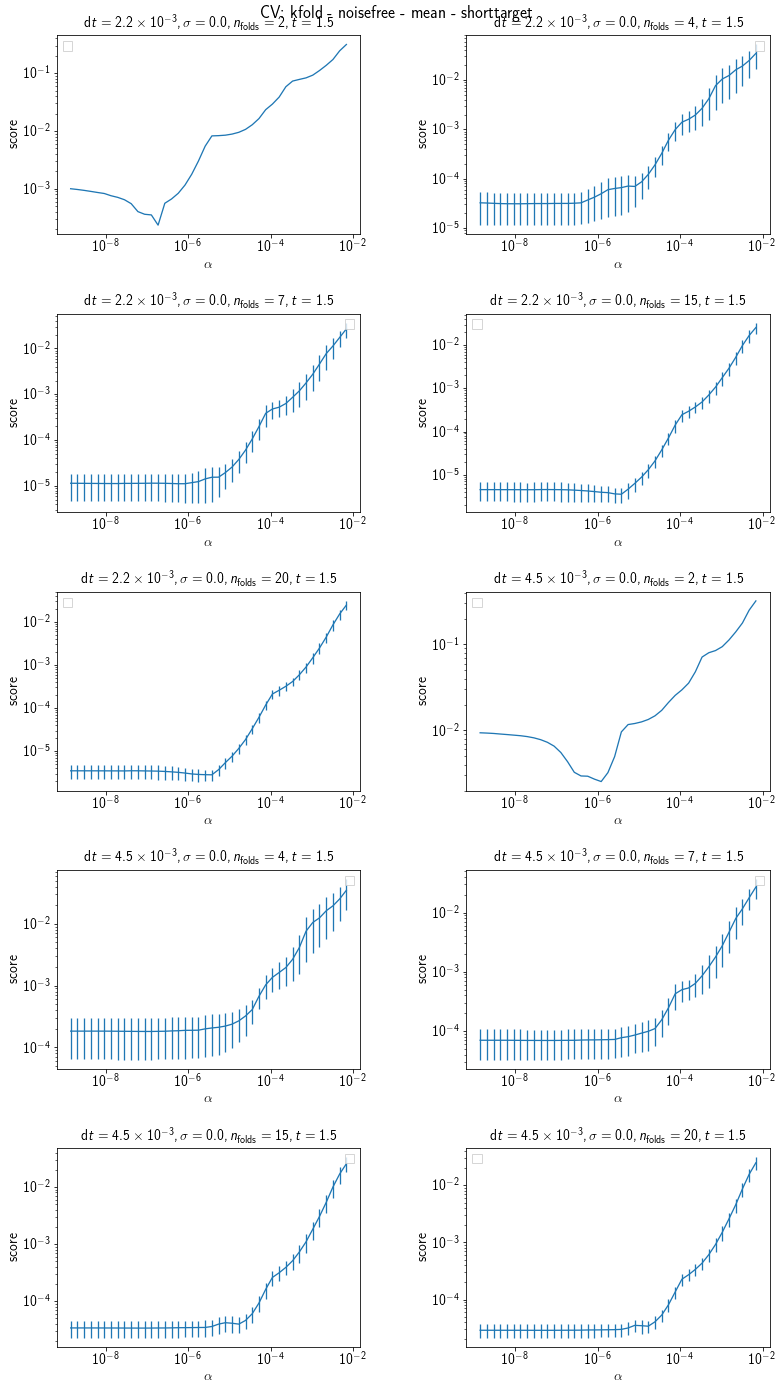

In [116]:
plot_overview(pfs, n_rows=5, n_cols=2, size_factor=1.1)
plt.suptitle("CV: kfold - noisefree - mean - shorttarget")
plt.savefig("kfold-noisefree-mean-shorttarget.pdf", bbox_inches="tight", transparent=False)

# Sample gaussian noise

In [117]:
data_dir = putils.data_dir(8)
data_dir

'/srv/public/workspace/data/rlearn-8'

In [118]:
all_samples = sb.list_of_samples(data_dir)
n_done = sum([1 for s in all_samples if s.done])
n_total = len(all_samples)
print(n_done, "/", n_total)

1500 / 1500


In [119]:
for s in all_samples:
    if s.done:
        scores = np.array(s.result[0]["score"])
        n_scores = len(scores)
        print("n_scores={}".format(n_scores))
        print("n_splits={}".format(s.args["n_splits"]))
        #s.result[0]["score_mean"] = np.mean(scores)
        #s.result[0]["score_dev"] = np.std(scores)
        #s.result[0]["score_err"] = np.std(scores) / np.sqrt(n_scores)

n_scores=2
n_splits=2
n_scores=2
n_splits=2
n_scores=4
n_splits=4
n_scores=2
n_splits=2
n_scores=20
n_splits=20
n_scores=2
n_splits=2
n_scores=4
n_splits=4
n_scores=7
n_splits=7
n_scores=15
n_splits=15
n_scores=7
n_splits=7
n_scores=7
n_splits=7
n_scores=4
n_splits=4
n_scores=20
n_splits=20
n_scores=4
n_splits=4
n_scores=2
n_splits=2
n_scores=15
n_splits=15
n_scores=4
n_splits=4
n_scores=2
n_splits=2
n_scores=15
n_splits=15
n_scores=20
n_splits=20
n_scores=4
n_splits=4
n_scores=2
n_splits=2
n_scores=2
n_splits=2
n_scores=7
n_splits=7
n_scores=20
n_splits=20
n_scores=4
n_splits=4
n_scores=4
n_splits=4
n_scores=7
n_splits=7
n_scores=4
n_splits=4
n_scores=2
n_splits=2
n_scores=2
n_splits=2
n_scores=20
n_splits=20
n_scores=15
n_splits=15
n_scores=15
n_splits=15
n_scores=15
n_splits=15
n_scores=2
n_splits=2
n_scores=4
n_splits=4
n_scores=7
n_splits=7
n_scores=15
n_splits=15
n_scores=7
n_splits=7
n_scores=20
n_splits=20
n_scores=2
n_splits=2
n_scores=20
n_splits=20
n_scores=20
n_splits=20
n_

n_scores=7
n_splits=7
n_scores=2
n_splits=2
n_scores=4
n_splits=4
n_scores=15
n_splits=15
n_scores=7
n_splits=7
n_scores=7
n_splits=7
n_scores=15
n_splits=15
n_scores=7
n_splits=7
n_scores=2
n_splits=2
n_scores=7
n_splits=7
n_scores=4
n_splits=4
n_scores=15
n_splits=15
n_scores=2
n_splits=2
n_scores=4
n_splits=4
n_scores=7
n_splits=7
n_scores=15
n_splits=15
n_scores=20
n_splits=20
n_scores=7
n_splits=7
n_scores=4
n_splits=4
n_scores=2
n_splits=2
n_scores=15
n_splits=15
n_scores=20
n_splits=20
n_scores=4
n_splits=4
n_scores=20
n_splits=20
n_scores=2
n_splits=2
n_scores=15
n_splits=15
n_scores=4
n_splits=4
n_scores=7
n_splits=7
n_scores=20
n_splits=20
n_scores=15
n_splits=15
n_scores=7
n_splits=7
n_scores=20
n_splits=20
n_scores=4
n_splits=4
n_scores=7
n_splits=7
n_scores=2
n_splits=2
n_scores=2
n_splits=2
n_scores=15
n_splits=15
n_scores=4
n_splits=4
n_scores=2
n_splits=2
n_scores=20
n_splits=20
n_scores=20
n_splits=20
n_scores=7
n_splits=7
n_scores=7
n_splits=7
n_scores=4
n_splits=4
n_

In [120]:
alphas = set()
timesteps = set()
noises = set()
folds = set()
for s in all_samples:
    if s.done:
        alphas.add(s.result[0]["alpha"])
        timesteps.add(s.args["dt"])
        noises.add(s.args["noise"])
        folds.add(s.args["n_splits"])
alphas = np.fromiter(alphas, dtype=float)
alphas.sort()
timesteps = np.fromiter(timesteps, dtype=float)
timesteps.sort()
noises = np.fromiter(noises, dtype=float)
noises.sort()
folds = np.fromiter(folds, dtype=int)
folds.sort()
print(alphas)
print(timesteps)
print(noises)
print(folds)

[1.00000000e-10 1.45634848e-10 2.12095089e-10 3.08884360e-10
 4.49843267e-10 6.55128557e-10 9.54095476e-10 1.38949549e-09
 2.02358965e-09 2.94705170e-09 4.29193426e-09 6.25055193e-09
 9.10298178e-09 1.32571137e-08 1.93069773e-08 2.81176870e-08
 4.09491506e-08 5.96362332e-08 8.68511374e-08 1.26485522e-07
 1.84206997e-07 2.68269580e-07 3.90693994e-07 5.68986603e-07
 8.28642773e-07 1.20679264e-06 1.75751062e-06 2.55954792e-06
 3.72759372e-06 5.42867544e-06 7.90604321e-06 1.15139540e-05
 1.67683294e-05 2.44205309e-05 3.55648031e-05 5.17947468e-05
 7.54312006e-05 1.09854114e-04 1.59985872e-04 2.32995181e-04
 3.39322177e-04 4.94171336e-04 7.19685673e-04 1.04811313e-03
 1.52641797e-03 2.22299648e-03 3.23745754e-03 4.71486636e-03
 6.86648845e-03 1.00000000e-02]
[0.00225 0.0045 ]
[1.e-09 1.e-08 1.e-07]
[ 2  4  7 15 20]


In [121]:
samples = cluster_along_arg(all_samples, "noise", noises)
for n in samples.keys():
    samples[n] = cluster_along_arg(samples[n], "dt", timesteps)
    for dt in samples[n].keys():
        samples[n][dt] = cluster_along_arg(samples[n][dt], "n_splits", folds)

In [123]:
all_samples[0].result[0]

{'alpha': 5.428675439323859e-06,
 'cutoff': 0.0,
 'l1_ratio': 1.0,
 'score': [-4.89909003335529, -0.011355679983743004]}

In [126]:
plt.rcParams.update({"font.size": 14})
pfs = []
def pf_(alphas, scores, timestep, noise, target_time, mean=False):
    #if abs(timestep - 0.00412) < 1e-6 and abs(noise - 1e-8) < 1e-12:
    #    plt.gca().set_axis_bgcolor('#FFCFC5')
    #    plt.text(0.5, 0.5,'initial set of parameters\n(roughly)', 
    #             horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    #else:
    n_folds = len(scores[0])
    if mean:
        exclude_first = scores[:, 1:]
        mean_scores = np.mean(exclude_first, axis=1)
        err_scores = np.std(exclude_first, axis=1) / np.sqrt(n_folds-1 if n_folds>2 else 1)
        plt.errorbar(alphas, - mean_scores, yerr=err_scores)
    else:
        for i in range(1, n_folds):
            if i < 7:
                plt.plot(alphas, - scores[:,i], label=str(i))
    text_str = r"$\mathrm{d}t="+to_latex_value(timestep)+r",\sigma="+str(noise)+r", n_\mathrm{folds}="+str(n_folds)+",t="+str(target_time)+"$"
    #plt.text(0.5, 0.5,text_str, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    plt.title(text_str)
    plt.legend()
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel(r"$\alpha$")
    plt.ylabel("score")

for n, samples_n in samples.items():
    for dt, samples_dt in samples_n.items():
        for f, samples_dt_f in samples_dt.items():
            done_samples = [s for s in samples_dt_f if s.done and 1e-9 < s.args["alpha"] < 1e-2]
            sorted_samples = sorted(done_samples, key=lambda x: x.args["alpha"])
            scores = np.array([ np.array(s.result[0]["score"]) for s in sorted_samples])
            #print(scores)
            min_indices = np.argmin(-scores)
            alphas = np.array([ s.args["alpha"] for s in sorted_samples])
            target_time = sorted_samples[0].args["target_time"]
            pfs.append(
                lambda a_=alphas, s_=scores, dt_=dt, n_=n, target_=target_time: pf_(
                    alphas=a_, scores=s_, timestep=dt_, noise=n_, target_time=target_, mean=True
                )
            )

[samplebase] [2018-03-05 16:09:50] [WARNING] No handles with labels found to put in legend.
[samplebase] [2018-03-05 16:09:50] [WARNING] No handles with labels found to put in legend.
[samplebase] [2018-03-05 16:09:50] [WARNING] No handles with labels found to put in legend.
[samplebase] [2018-03-05 16:09:51] [WARNING] No handles with labels found to put in legend.
[samplebase] [2018-03-05 16:09:51] [WARNING] No handles with labels found to put in legend.
[samplebase] [2018-03-05 16:09:51] [WARNING] No handles with labels found to put in legend.
[samplebase] [2018-03-05 16:09:51] [WARNING] No handles with labels found to put in legend.
[samplebase] [2018-03-05 16:09:51] [WARNING] No handles with labels found to put in legend.
[samplebase] [2018-03-05 16:09:51] [WARNING] No handles with labels found to put in legend.
[samplebase] [2018-03-05 16:09:51] [WARNING] No handles with labels found to put in legend.
[samplebase] [2018-03-05 16:09:51] [WARNING] No handles with labels found to put

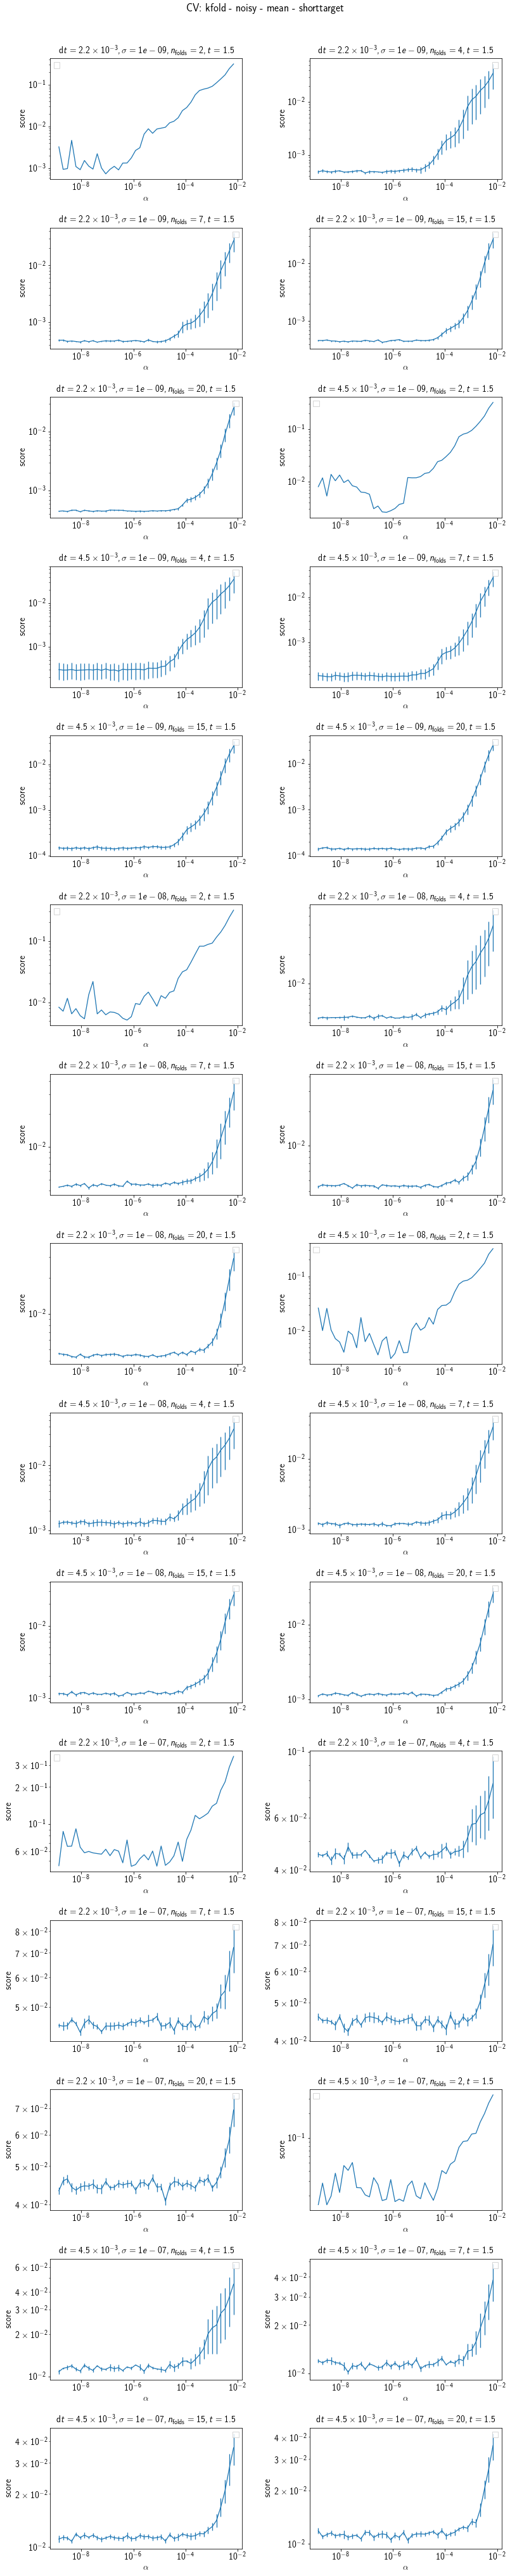

In [127]:
plot_overview(pfs, n_rows=15, n_cols=2, size_factor=1.1)
plt.suptitle("CV: kfold - noisy - mean - shorttarget")
plt.savefig("kfold-noisy-mean-shorttarget.pdf", bbox_inches="tight", transparent=False)

# Sample Gillespie realisations

In [5]:
data_dir = putils.data_dir(11)
data_dir

'/srv/public/workspace/data/rlearn-11'

In [6]:
all_samples = sb.list_of_samples(data_dir)
n_done = sum([1 for s in all_samples if s.done])
n_total = len(all_samples)
print(n_done, "/", n_total)

2250 / 2250


In [16]:
all_samples[0].args

{'alpha': 5.689866029018293e-07,
 'dt': 0.00225,
 'gillespie_realisations': 500,
 'n_splits': 7,
 'noise': 0.0,
 'target_time': 1.5}

In [11]:
alphas = set()
timesteps = set()
noises = set()
folds = set()
gillespie_realisations = set()
for s in all_samples:
    if s.done:
        alphas.add(s.args["alpha"])
        timesteps.add(s.args["dt"])
        noises.add(s.args["noise"])
        folds.add(s.args["n_splits"])
        gillespie_realisations.add(s.args["gillespie_realisations"])
alphas = np.fromiter(alphas, dtype=float)
alphas.sort()
timesteps = np.fromiter(timesteps, dtype=float)
timesteps.sort()
noises = np.fromiter(noises, dtype=float)
noises.sort()
folds = np.fromiter(folds, dtype=int)
folds.sort()
gillespie_realisations = np.fromiter(gillespie_realisations, dtype=int)
gillespie_realisations.sort()
print(alphas)
print(timesteps)
print(noises)
print(folds)
print(gillespie_realisation)

[1.00000000e-10 1.45634848e-10 2.12095089e-10 3.08884360e-10
 4.49843267e-10 6.55128557e-10 9.54095476e-10 1.38949549e-09
 2.02358965e-09 2.94705170e-09 4.29193426e-09 6.25055193e-09
 9.10298178e-09 1.32571137e-08 1.93069773e-08 2.81176870e-08
 4.09491506e-08 5.96362332e-08 8.68511374e-08 1.26485522e-07
 1.84206997e-07 2.68269580e-07 3.90693994e-07 5.68986603e-07
 8.28642773e-07 1.20679264e-06 1.75751062e-06 2.55954792e-06
 3.72759372e-06 5.42867544e-06 7.90604321e-06 1.15139540e-05
 1.67683294e-05 2.44205309e-05 3.55648031e-05 5.17947468e-05
 7.54312006e-05 1.09854114e-04 1.59985872e-04 2.32995181e-04
 3.39322177e-04 4.94171336e-04 7.19685673e-04 1.04811313e-03
 1.52641797e-03 2.22299648e-03 3.23745754e-03 4.71486636e-03
 6.86648845e-03 1.00000000e-02]
[0.00225]
[0.]
[ 4  7 15 20 30]
[  1   2   5  10  20  50 100 200 500]


In [12]:
samples = cluster_along_arg(all_samples, "gillespie_realisations", gillespie_realisations)
for gr in samples.keys():
    samples[gr] = cluster_along_arg(samples[gr], "n_splits", folds)

In [81]:
all_samples[1].result

{'counts': array([[1.0000e+00, 2.0000e+00, 0.0000e+00, ..., 1.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.0000e+00, 1.9578e+00, 1.0000e-02, ..., 1.0000e+00, 6.0000e-03,
         2.0000e-04],
        [1.0000e+00, 1.9204e+00, 2.0600e-02, ..., 1.0000e+00, 1.1000e-02,
         2.0000e-04],
        ...,
        [1.0000e+00, 6.2940e-01, 6.5300e-01, ..., 1.0000e+00, 5.6360e-01,
         6.8040e-01],
        [1.0000e+00, 6.2880e-01, 6.5540e-01, ..., 1.0000e+00, 5.6220e-01,
         6.7800e-01],
        [1.0000e+00, 6.2720e-01, 6.5620e-01, ..., 1.0000e+00, 5.5840e-01,
         6.7740e-01]]),
 'cv_result': [{'alpha': 2.0235896477251556e-09,
   'cutoff': 0.0,
   'l1_ratio': 1.0,
   'score': [-0.000977416358990535,
    -1.370742243865375e-06,
    -3.4485392190677327e-06,
    -4.975079743064712e-06,
    -2.268591322767462e-06,
    -1.527827305865165e-07,
    -6.742459849046657e-07,
    -2.3285235925332583e-06,
    -3.864207533796096e-06,
    -4.145347626562805e-06,
    -2.846718312919508

In [80]:
plt.rcParams.update({"font.size": 12})
pfs = []
def pf_(alphas, scores, timestep, noise, target_time, n_gillespie_realisations, mean=False):
    """scores.shape = (n_alphas, n_folds)"""
    n_folds = len(scores[0])
    if mean:
        exclude_first = scores[:, 1:]
        mean_scores = np.mean(exclude_first, axis=1)
        err_scores = np.std(exclude_first, axis=1) / np.sqrt(n_folds-1 if n_folds>2 else 1)
        plt.errorbar(alphas, - mean_scores, yerr=err_scores)
    else:
        for i in range(1, n_folds):
            if i < 7:
                plt.plot(alphas, - scores[:,i], label=str(i))
    text_str = r"$\mathrm{d}t="+to_latex_value(timestep)+r", n_\mathrm{folds}="+str(n_folds)+",t="+str(target_time)+",n_\mathrm{real}="+str(n_gillespie_realisations)+"$"
    #plt.text(0.5, 0.5,text_str, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    plt.title(text_str, fontsize=9)
    plt.legend()
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel(r"$\alpha$")
    plt.ylabel("score")


mean = True
scores_2 = []
for gr, samples_gr in samples.items():
    for f, samples_gr_f in samples_gr.items():
        
        done_samples = [s for s in samples_gr_f if s.done and 1e-9 < s.args["alpha"] < 1e-2]
        sorted_samples = sorted(done_samples, key=lambda x: x.args["alpha"])
        scores = np.array([ np.array(s.result["cv_result"][0]["score"]) for s in sorted_samples])
        #print(scores)
        min_indices = np.argmin(-scores)
        alphas = np.array([ s.args["alpha"] for s in sorted_samples])
        target_time = sorted_samples[0].args["target_time"]
        dt = sorted_samples[0].args["dt"]    
        pfs.append(
            lambda a_=alphas, s_=scores, dt_=dt, n_=None, target_=target_time, gr_=gr: pf_(
                alphas=a_, scores=s_, timestep=dt_, noise=n_, target_time=target_, 
                n_gillespie_realisations=gr_, mean=True
            )
        )
        if mean and f==15:
            exclude_first = scores[:, 1:]
            mean_scores = np.mean(exclude_first, axis=1)
            scores_2.append(mean_scores)


[<samplebase.sample.Sample object at 0x7f73982eeb70>, <samplebase.sample.Sample object at 0x7f7398319fd0>, <samplebase.sample.Sample object at 0x7f73982b8f60>, <samplebase.sample.Sample object at 0x7f739828a9b0>, <samplebase.sample.Sample object at 0x7f7398294be0>, <samplebase.sample.Sample object at 0x7f7398242d68>, <samplebase.sample.Sample object at 0x7f7398173c18>, <samplebase.sample.Sample object at 0x7f739818af98>, <samplebase.sample.Sample object at 0x7f7398125b70>, <samplebase.sample.Sample object at 0x7f739812df60>, <samplebase.sample.Sample object at 0x7f739813be80>, <samplebase.sample.Sample object at 0x7f73980e2b38>, <samplebase.sample.Sample object at 0x7f73980f8a58>, <samplebase.sample.Sample object at 0x7f73980c1f98>, <samplebase.sample.Sample object at 0x7f739807cf98>, <samplebase.sample.Sample object at 0x7f7398092f28>, <samplebase.sample.Sample object at 0x7f739802aa20>, <samplebase.sample.Sample object at 0x7f7398054b70>, <samplebase.sample.Sample object at 0x7f7397f

In [79]:
for s in scores_2:
    print(s[30])

-0.000244532452209143
-0.0002445324522086922
-0.0002445324522086922
-0.0002445324522086922
-0.000244532452209143
-0.0002445324522086922
-0.0002445324522086922
-0.0002445324522086922
-0.000244532452209143


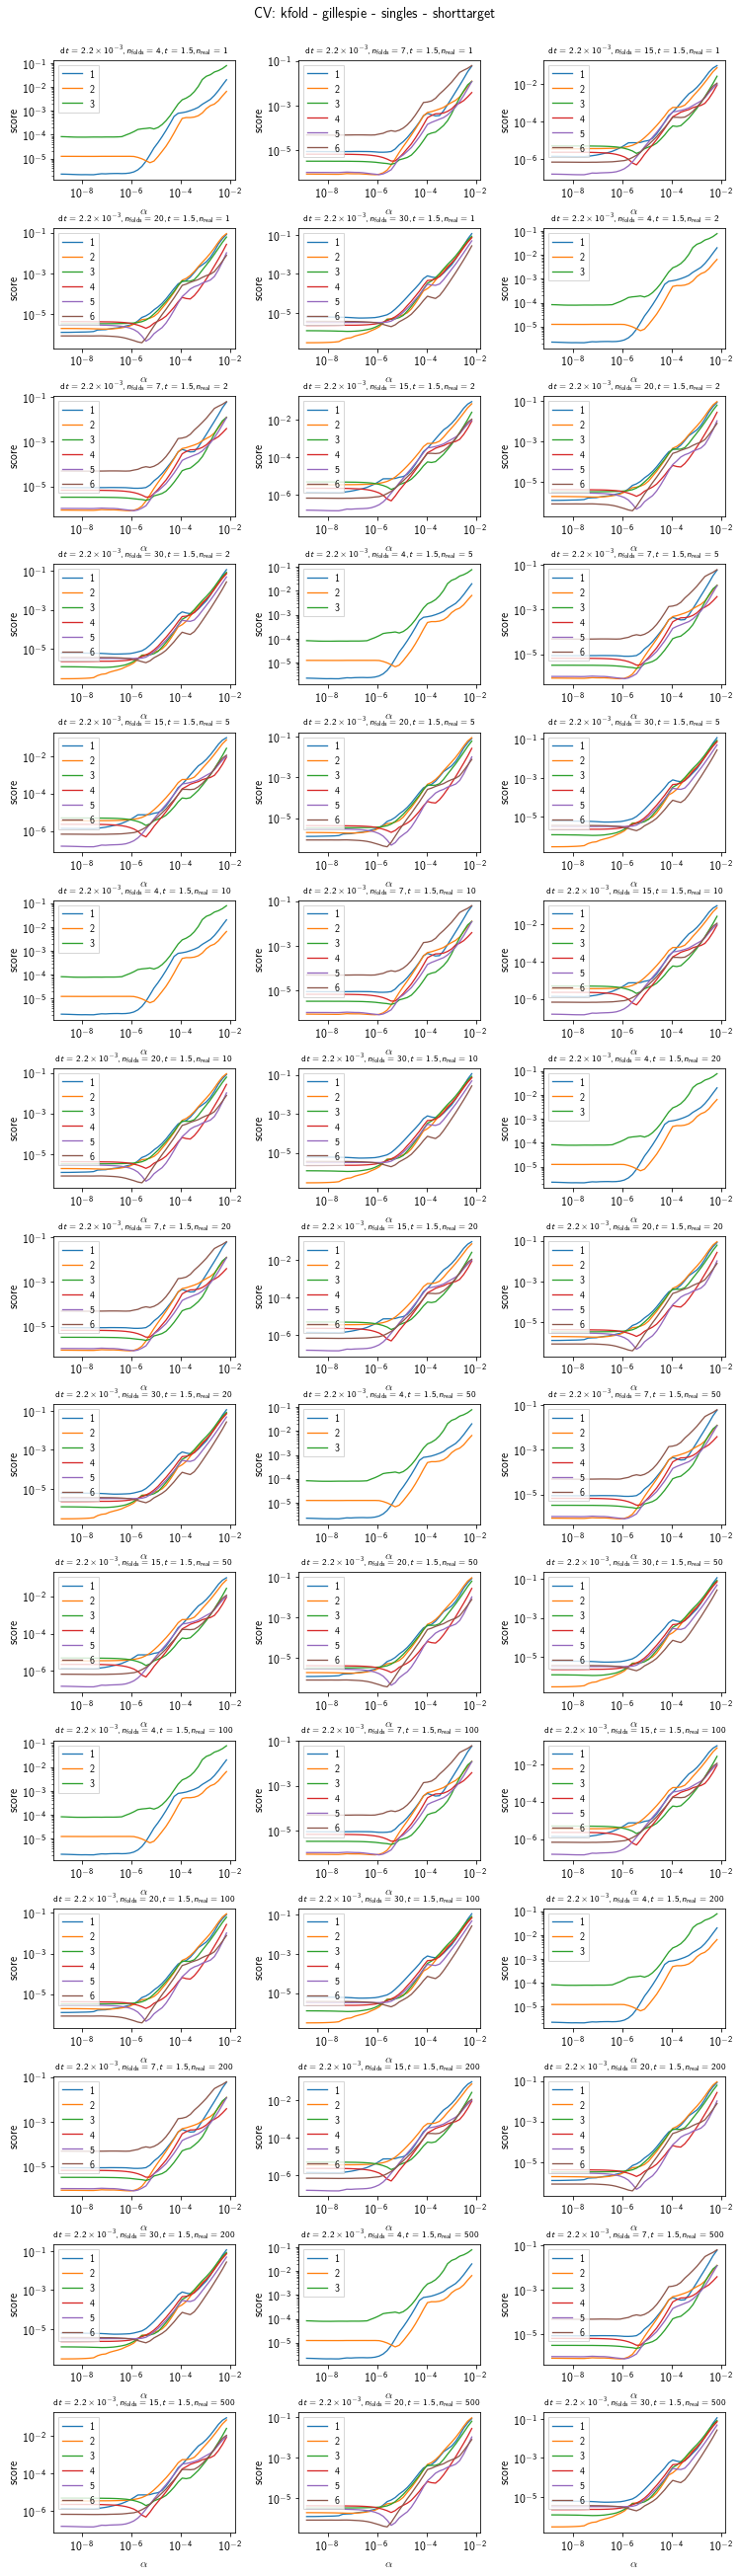

In [47]:
plot_overview(pfs, n_rows=15, n_cols=3, size_factor=0.7)
plt.suptitle("CV: kfold - gillespie - singles - shorttarget")
plt.savefig("cv-kfold-gillespie-singles-shorttarget.pdf", bbox_inches="tight", transparent=False)

In [44]:
def pf_traj_(traj_counts, timestep, noise, target_time, n_gillespie_realisations, n_folds, mean=False):
    for counts in traj_counts:
        plt.plot(counts, alpha=0.1)
    text_str = r"$\mathrm{d}t="+to_latex_value(timestep)+r", n_\mathrm{folds}="+str(n_folds)+",t="+str(target_time)+",n_\mathrm{real}="+str(n_gillespie_realisations)+"$"
    #plt.text(0.5, 0.5,text_str, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    plt.title(text_str, fontsize=9)
    plt.legend()

pfs = []
for gr, samples_gr in samples.items():
    for f, samples_gr_f in samples_gr.items():
        done_samples = [s for s in samples_gr_f if s.done and 1e-9 < s.args["alpha"] < 1e-2]
        sorted_samples = sorted(done_samples, key=lambda x: x.args["alpha"])
        scores = np.array([ np.array(s.result["cv_result"][0]["score"]) for s in sorted_samples])
        #print(scores)
        min_indices = np.argmin(-scores)
        alphas = np.array([ s.args["alpha"] for s in sorted_samples])
        target_time = sorted_samples[0].args["target_time"]
        dt = sorted_samples[0].args["dt"]
        n_folds = sorted_samples[0].args["n_splits"]
        traj_counts = [ s.result["counts"] for s in sorted_samples ]
        print(traj_counts)
        pfs.append(
            lambda tc_=traj_counts, dt_=dt, n_=None, target_=target_time, gr_=gr, nf_=n_folds: pf_traj_(
                traj_counts=tc_, timestep=dt_, noise=n_, target_time=target_, 
                n_gillespie_realisations=gr_, n_folds=nf_, mean=True
            )
        )

[array([[1.  , 2.  , 0.  , ..., 1.  , 0.  , 0.  ],
       [1.  , 1.97, 0.01, ..., 1.  , 0.  , 0.  ],
       [1.  , 1.92, 0.03, ..., 1.  , 0.  , 0.  ],
       ...,
       [1.  , 0.64, 0.6 , ..., 1.  , 0.48, 0.65],
       [1.  , 0.64, 0.58, ..., 1.  , 0.48, 0.65],
       [1.  , 0.63, 0.58, ..., 1.  , 0.49, 0.64]]), array([[1.  , 2.  , 0.  , ..., 1.  , 0.  , 0.  ],
       [1.  , 1.98, 0.  , ..., 1.  , 0.01, 0.  ],
       [1.  , 1.91, 0.02, ..., 1.  , 0.01, 0.  ],
       ...,
       [1.  , 0.48, 0.54, ..., 1.  , 0.56, 0.79],
       [1.  , 0.5 , 0.55, ..., 1.  , 0.56, 0.79],
       [1.  , 0.5 , 0.55, ..., 1.  , 0.58, 0.8 ]]), array([[1.  , 2.  , 0.  , ..., 1.  , 0.  , 0.  ],
       [1.  , 1.99, 0.  , ..., 1.  , 0.  , 0.  ],
       [1.  , 1.94, 0.01, ..., 1.  , 0.  , 0.  ],
       ...,
       [1.  , 0.55, 0.75, ..., 1.  , 0.36, 0.57],
       [1.  , 0.55, 0.76, ..., 1.  , 0.35, 0.55],
       [1.  , 0.55, 0.76, ..., 1.  , 0.35, 0.55]]), array([[1.  , 2.  , 0.  , ..., 1.  , 0.  , 0.  ],
       

[array([[1.   , 2.   , 0.   , ..., 1.   , 0.   , 0.   ],
       [1.   , 1.955, 0.011, ..., 1.   , 0.01 , 0.   ],
       [1.   , 1.911, 0.031, ..., 1.   , 0.017, 0.   ],
       ...,
       [1.   , 0.6  , 0.634, ..., 1.   , 0.55 , 0.663],
       [1.   , 0.597, 0.639, ..., 1.   , 0.545, 0.658],
       [1.   , 0.599, 0.641, ..., 1.   , 0.545, 0.656]]), array([[1.   , 2.   , 0.   , ..., 1.   , 0.   , 0.   ],
       [1.   , 1.953, 0.008, ..., 1.   , 0.006, 0.   ],
       [1.   , 1.911, 0.013, ..., 1.   , 0.016, 0.   ],
       ...,
       [1.   , 0.56 , 0.565, ..., 1.   , 0.541, 0.702],
       [1.   , 0.56 , 0.567, ..., 1.   , 0.54 , 0.701],
       [1.   , 0.56 , 0.568, ..., 1.   , 0.541, 0.699]]), array([[1.   , 2.   , 0.   , ..., 1.   , 0.   , 0.   ],
       [1.   , 1.954, 0.013, ..., 1.   , 0.009, 0.   ],
       [1.   , 1.903, 0.023, ..., 1.   , 0.014, 0.   ],
       ...,
       [1.   , 0.615, 0.632, ..., 1.   , 0.542, 0.691],
       [1.   , 0.613, 0.636, ..., 1.   , 0.544, 0.692],
       

[array([[1.0000e+00, 2.0000e+00, 0.0000e+00, ..., 1.0000e+00, 0.0000e+00,
        0.0000e+00],
       [1.0000e+00, 1.9522e+00, 9.4000e-03, ..., 1.0000e+00, 7.1000e-03,
        0.0000e+00],
       [1.0000e+00, 1.9094e+00, 1.6700e-02, ..., 1.0000e+00, 1.4300e-02,
        1.0000e-04],
       ...,
       [1.0000e+00, 6.0970e-01, 6.4680e-01, ..., 1.0000e+00, 5.4570e-01,
        6.7130e-01],
       [1.0000e+00, 6.1040e-01, 6.4770e-01, ..., 1.0000e+00, 5.4700e-01,
        6.7110e-01],
       [1.0000e+00, 6.1240e-01, 6.4860e-01, ..., 1.0000e+00, 5.4770e-01,
        6.7270e-01]]), array([[1.0000e+00, 2.0000e+00, 0.0000e+00, ..., 1.0000e+00, 0.0000e+00,
        0.0000e+00],
       [1.0000e+00, 1.9530e+00, 1.3100e-02, ..., 1.0000e+00, 8.0000e-03,
        1.0000e-04],
       [1.0000e+00, 1.9141e+00, 2.3400e-02, ..., 1.0000e+00, 1.7000e-02,
        4.0000e-04],
       ...,
       [1.0000e+00, 5.9000e-01, 6.5450e-01, ..., 1.0000e+00, 5.2820e-01,
        6.5960e-01],
       [1.0000e+00, 5.9090e-01, 6

[samplebase] [2018-03-08 15:50:30] [WARNING] No handles with labels found to put in legend.
[samplebase] [2018-03-08 15:50:30] [WARNING] No handles with labels found to put in legend.
[samplebase] [2018-03-08 15:50:31] [WARNING] No handles with labels found to put in legend.
[samplebase] [2018-03-08 15:50:31] [WARNING] No handles with labels found to put in legend.
[samplebase] [2018-03-08 15:50:31] [WARNING] No handles with labels found to put in legend.
[samplebase] [2018-03-08 15:50:31] [WARNING] No handles with labels found to put in legend.
[samplebase] [2018-03-08 15:50:31] [WARNING] No handles with labels found to put in legend.
[samplebase] [2018-03-08 15:50:31] [WARNING] No handles with labels found to put in legend.
[samplebase] [2018-03-08 15:50:32] [WARNING] No handles with labels found to put in legend.
[samplebase] [2018-03-08 15:50:32] [WARNING] No handles with labels found to put in legend.
[samplebase] [2018-03-08 15:50:32] [WARNING] No handles with labels found to put

Text(0.5,0.98,'trajs: kfold - gillespie - mean - shorttarget')

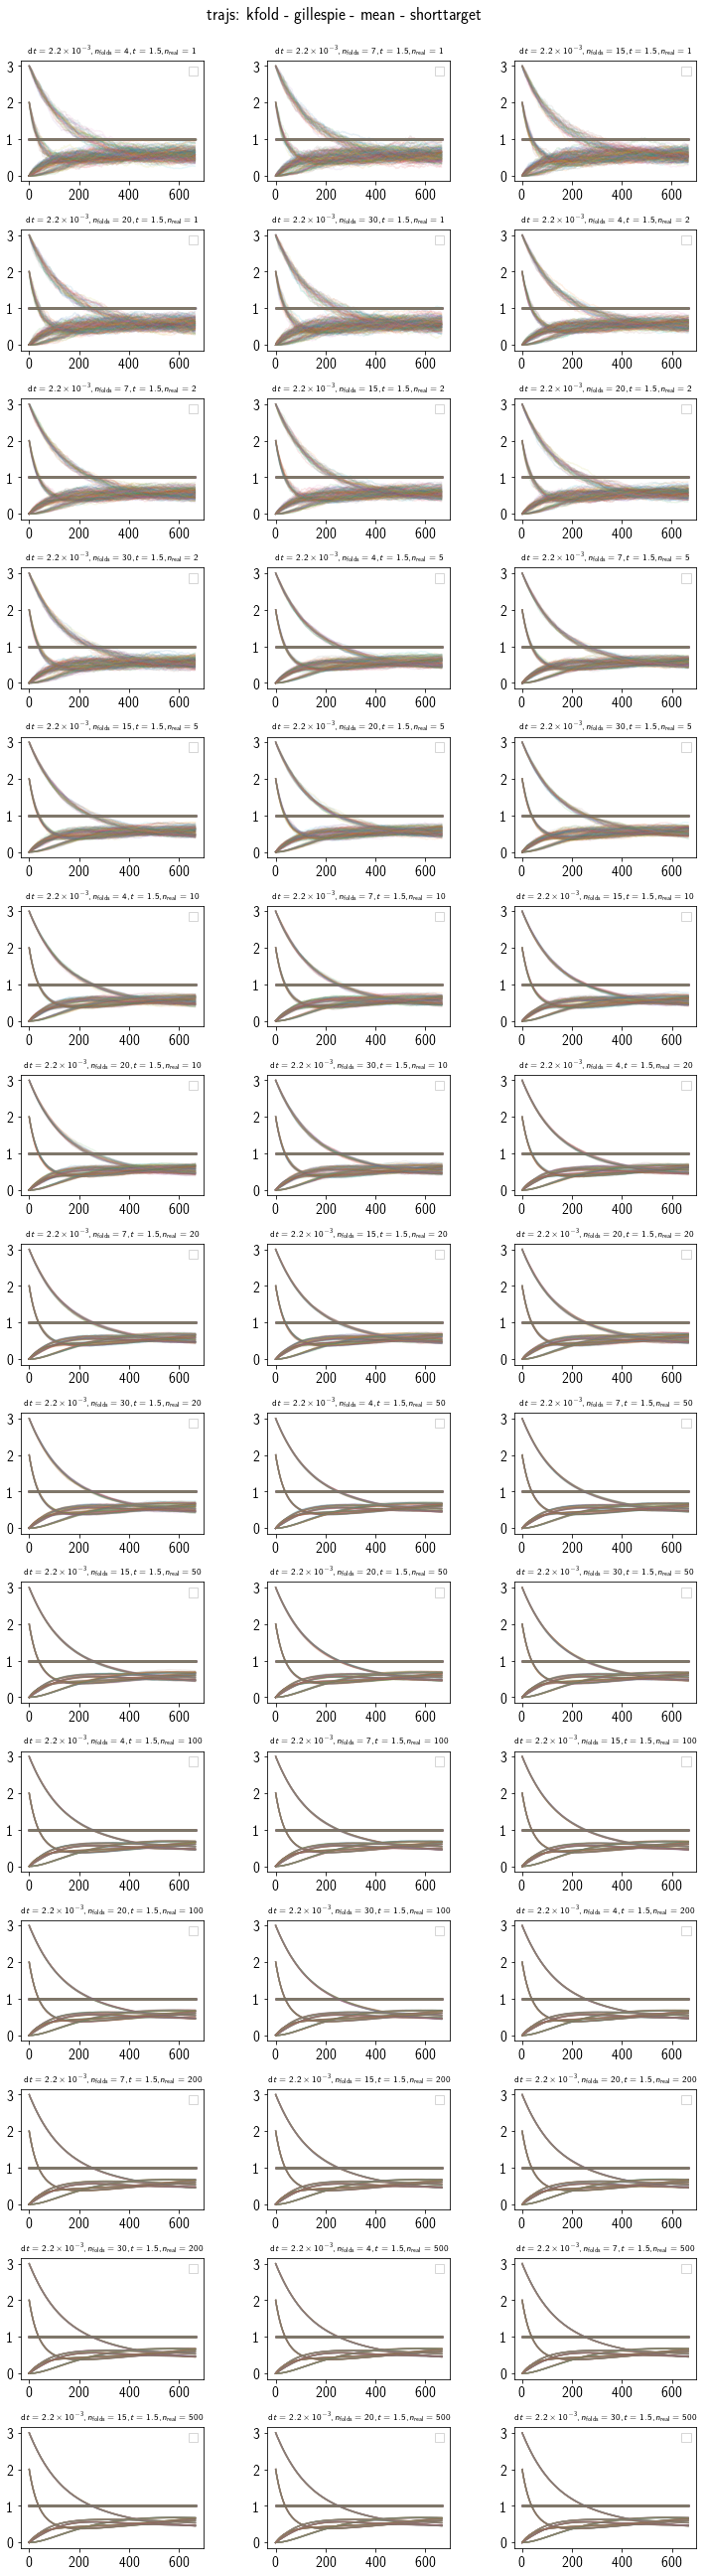

In [45]:
plot_overview(pfs, n_rows=15, n_cols=3, size_factor=0.7)
plt.suptitle("trajs: kfold - gillespie - mean - shorttarget")

In [50]:
#import sys
#sys.path.append("/home/mi/chrisfr/workspace/readdy_learn_pycharm")
import readdy_learn.analyze.basis as basis
import readdy_learn.analyze.cross_validation as cross_validation
from readdy_learn.example.regulation_network import RegulationNetwork
from readdy_learn.example.regulation_network import DEFAULT_DESIRED_RATES

/srv/public/miniconda3/envs/rlearn/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [67]:
def pf_solutions_(estimated_rates, timestep, noise, target_time, n_gillespie_realisations, n_folds, mean=False):
    #print("desired_rates", len(desired_rates))
    #print("estimated_rates", len(estimated_rates))
    assert len(desired_rates) == len(estimated_rates)
    N = len(desired_rates)
    ind = np.arange(N)
    width = .35
    ax = plt.gca()
    bar1 = ax.bar(ind, desired_rates, width, color="C0")
    bar2 = ax.bar(ind + width, estimated_rates, width, color="C1")
    ax.set_xticks(ind + width / 2)
    ax.legend((bar1[0], bar2[0]), ('Desired', 'Estimated'))
    ax.set_xticklabels(["" for i in ind])
    text_str = r"$\mathrm{d}t="+to_latex_value(timestep)+r", n_\mathrm{folds}="+str(n_folds)+",t="+str(target_time)+",n_\mathrm{real}="+str(n_gillespie_realisations)+"$"
    #plt.text(0.5, 0.5,text_str, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    plt.title(text_str, fontsize=9)
    plt.legend()

pfs = []
mean = True
regnetwork = RegulationNetwork()
desired_rates = np.concatenate((regnetwork.get_desired_rates(), np.zeros(2)))
for gr, samples_gr in samples.items():
    for f, samples_gr_f in samples_gr.items():
        done_samples = [s for s in samples_gr_f if s.done and 1e-9 < s.args["alpha"] < 1e-2]
        sorted_samples = sorted(done_samples, key=lambda x: x.args["alpha"])
        scores = np.array([ np.array(s.result["cv_result"][0]["score"]) for s in sorted_samples])
        if mean:
            exclude_first = scores[:, 1:]
            mean_scores = np.mean(exclude_first, axis=1)
            err_scores = np.std(exclude_first, axis=1) / np.sqrt(f-1 if f>2 else 1)
        #print(scores)
        min_indices = np.argmin(-mean_scores)
        #print("min_indices={} len(sorted_samples)={}".format(min_indices, len(sorted_samples)))
        alphas = np.array([ s.args["alpha"] for s in sorted_samples])
        target_time = sorted_samples[0].args["target_time"]
        dt = sorted_samples[0].args["dt"]
        n_folds = sorted_samples[0].args["n_splits"]
        traj_counts = [ s.result["counts"] for s in sorted_samples ]
        estimated_rates = sorted_samples[min_indices].result["estimated_rates"]
        best_alpha = sorted_samples[min_indices].args["alpha"]
        print("best_alpha", best_alpha)
        pfs.append(
            lambda er_=estimated_rates, dt_=dt, n_=None, target_=target_time, gr_=gr, nf_=n_folds: pf_solutions_(
                estimated_rates=er_, timestep=dt_, noise=n_, target_time=target_, 
                n_gillespie_realisations=gr_, n_folds=nf_, mean=True
            )
        )

best_alpha 1.3257113655901082e-08
best_alpha 5.689866029018293e-07
best_alpha 3.727593720314938e-06
best_alpha 3.727593720314938e-06
best_alpha 2.5595479226995334e-06
best_alpha 1.3257113655901082e-08
best_alpha 5.689866029018293e-07
best_alpha 3.727593720314938e-06
best_alpha 3.727593720314938e-06
best_alpha 2.5595479226995334e-06
best_alpha 1.3257113655901082e-08
best_alpha 5.689866029018293e-07
best_alpha 3.727593720314938e-06
best_alpha 3.727593720314938e-06
best_alpha 2.5595479226995334e-06
best_alpha 1.3257113655901082e-08
best_alpha 5.689866029018293e-07
best_alpha 3.727593720314938e-06
best_alpha 3.727593720314938e-06
best_alpha 2.5595479226995334e-06
best_alpha 1.3257113655901082e-08
best_alpha 5.689866029018293e-07
best_alpha 3.727593720314938e-06
best_alpha 3.727593720314938e-06
best_alpha 2.5595479226995334e-06
best_alpha 1.3257113655901082e-08
best_alpha 5.689866029018293e-07
best_alpha 3.727593720314938e-06
best_alpha 3.727593720314938e-06
best_alpha 2.5595479226995334e-0

[samplebase] [2018-03-08 16:22:10] [WARNING] No handles with labels found to put in legend.
[samplebase] [2018-03-08 16:22:11] [WARNING] No handles with labels found to put in legend.
[samplebase] [2018-03-08 16:22:11] [WARNING] No handles with labels found to put in legend.
[samplebase] [2018-03-08 16:22:11] [WARNING] No handles with labels found to put in legend.
[samplebase] [2018-03-08 16:22:11] [WARNING] No handles with labels found to put in legend.
[samplebase] [2018-03-08 16:22:11] [WARNING] No handles with labels found to put in legend.
[samplebase] [2018-03-08 16:22:11] [WARNING] No handles with labels found to put in legend.
[samplebase] [2018-03-08 16:22:11] [WARNING] No handles with labels found to put in legend.
[samplebase] [2018-03-08 16:22:11] [WARNING] No handles with labels found to put in legend.
[samplebase] [2018-03-08 16:22:11] [WARNING] No handles with labels found to put in legend.
[samplebase] [2018-03-08 16:22:11] [WARNING] No handles with labels found to put

Text(0.5,0.98,'best score models: kfold - gillespie - mean - shorttarget')

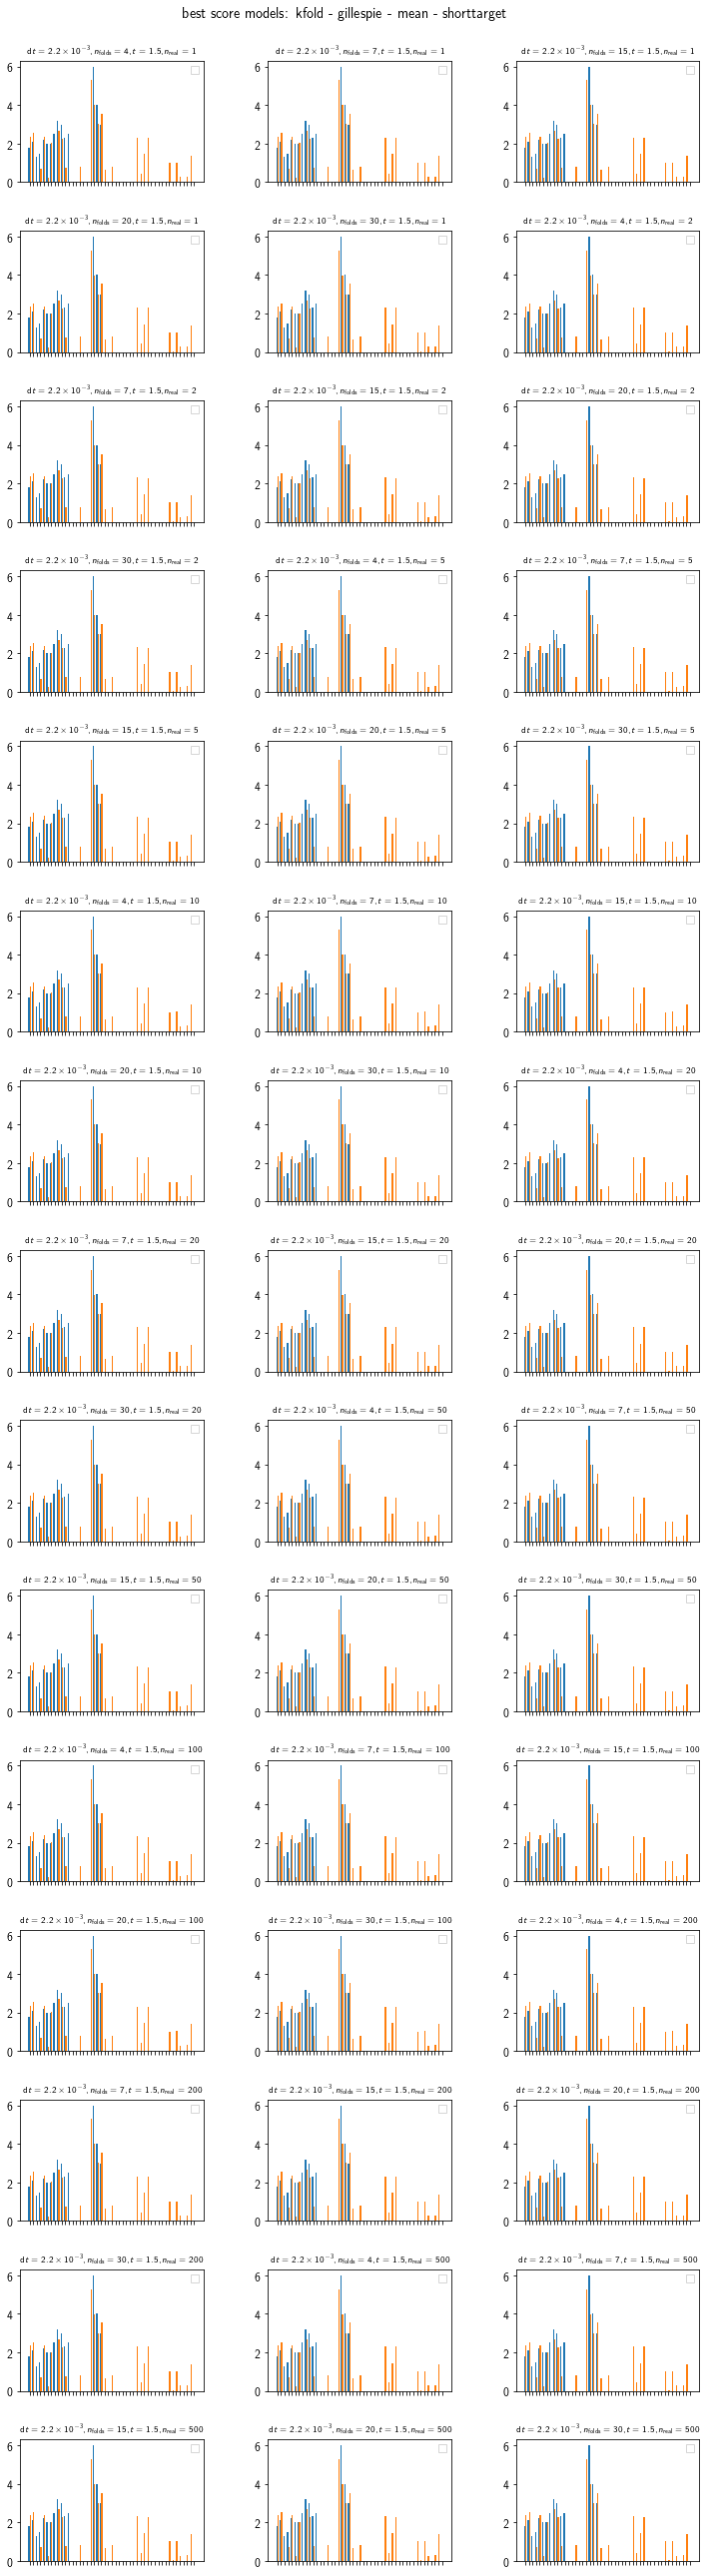

In [68]:
plot_overview(pfs, n_rows=15, n_cols=3, size_factor=0.7)
plt.suptitle("best score models, learned on all data: kfold - gillespie - mean - shorttarget")
